In [12]:
import numpy as np; np.random.seed(0)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df_train = pd.read_csv('/kaggle/input/machine-learning/sorptivity_train_cv.csv', delimiter=",")

df_train=df_train[:1296]
df_train

,sqrt_min,min,area,penetration
0,1.414214,2,0.121704,0.344828
1,1.414214,2,0.115340,0.344828
2,1.414214,2,0.116099,0.344828
3,1.414214,2,0.077640,0.229885
4,1.414214,2,0.195695,0.574713
...,...,...,...,...
1291,37.947332,1440,1.000008,3.037975
1292,37.947332,1440,1.000064,3.164557
1293,37.947332,1440,1.000006,3.164557
1294,37.947332,1440,1.000385,3.291139


In [13]:
df_test = pd.read_csv('/kaggle/input/machine-learning/sorptivity_test_csv.csv', delimiter=",")

df_test=df_test[:144]
df_test

,sqrt_min,min,area,penetration
0,2.236068,5,0.193498,0.574713
1,3.872983,15,0.243408,0.689655
2,4.472136,20,0.547945,1.609195
3,6.708204,45,0.541796,1.609195
4,8.660254,75,0.486815,1.379310
...,...,...,...,...
139,9.486833,90,0.958341,2.911392
140,10.954451,120,0.960000,3.037975
141,13.416408,180,0.960006,3.037975
142,18.973666,360,1.000008,3.037975


In [14]:
# assigning training and testing data frames 

train_df = df_train
test_df = df_test

#  converting tabular data to tensorflow

import tensorflow as tf
def convert_to_tensor(s):
    dt = s.dtype
    if dt == "float64" or dt=="float32" or dt == "int64":
        a = np.asarray(s).astype("float32")

# we did not normalized the variables to be able to compared predicted and true porosities.

        return a
    elif dt == "object":
        return s
    return None

def df_to_dataset(dataframe, target_name):
    data_dict = {}
    for col in dataframe.columns:
        t = convert_to_tensor(dataframe[col])
        if col == target_name:
            labels = t.astype("float32")
        elif t is not None:
            data_dict[col] = t
    ds = tf.data.Dataset.from_tensor_slices((data_dict, labels))
    return ds

# converting dataframe to dataset

train_data=df_to_dataset(train_df,"penetration")
test_data=df_to_dataset(test_df,"penetration")

absorp_time=tf.feature_column.numeric_column('sqrt_min')
absorp_percent=tf.feature_column.numeric_column('area')

feature_layer = tf.keras.layers.DenseFeatures([absorp_percent,absorp_time])

In [16]:
def create_model(learning_rate, feature_layer):
    model=tf.keras.Sequential()
    model.add(feature_layer)
    model.add(tf.keras.layers.Dense(units=64, activation ="relu"))
    model.add(tf.keras.layers.Dense(units=32, activation ="relu"))
    model.add(tf.keras.layers.Dense(units=16, activation ="relu"))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(units=1))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss="mean_squared_error", metrics=[tf.keras.metrics.MeanSquaredError()])
    
    return model

In [17]:
learning_rate= 0.00005
epochs = 500
batch_size= 16
model= create_model(learning_rate, feature_layer)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
history = model.fit(train_data.batch(batch_size),validation_data=test_data.batch(batch_size),epochs=epochs, shuffle=True,)
epochs = history.epoch
hist=pd.DataFrame(history.history)

Epoch 1/500
81/81 [==============================] - 2s 4ms/step - loss: 10.2102 - mean_squared_error: 10.2102 - val_loss: 7.8916 - val_mean_squared_error: 7.8916
Epoch 2/500
81/81 [==============================] - 0s 2ms/step - loss: 5.9734 - mean_squared_error: 5.9734 - val_loss: 5.0216 - val_mean_squared_error: 5.0216
Epoch 3/500
81/81 [==============================] - 0s 2ms/step - loss: 4.2471 - mean_squared_error: 4.2471 - val_loss: 3.7551 - val_mean_squared_error: 3.7551
Epoch 4/500
81/81 [==============================] - 0s 2ms/step - loss: 3.3778 - mean_squared_error: 3.3778 - val_loss: 3.1251 - val_mean_squared_error: 3.1251
Epoch 5/500
81/81 [==============================] - 0s 2ms/step - loss: 2.9425 - mean_squared_error: 2.9425 - val_loss: 2.7145 - val_mean_squared_error: 2.7145
Epoch 6/500
81/81 [==============================] - 0s 2ms/step - loss: 2.6650 - mean_squared_error: 2.6650 - val_loss: 2.4304 - val_mean_squared_error: 2.4304
Epoch 7/500
81/81 [=============

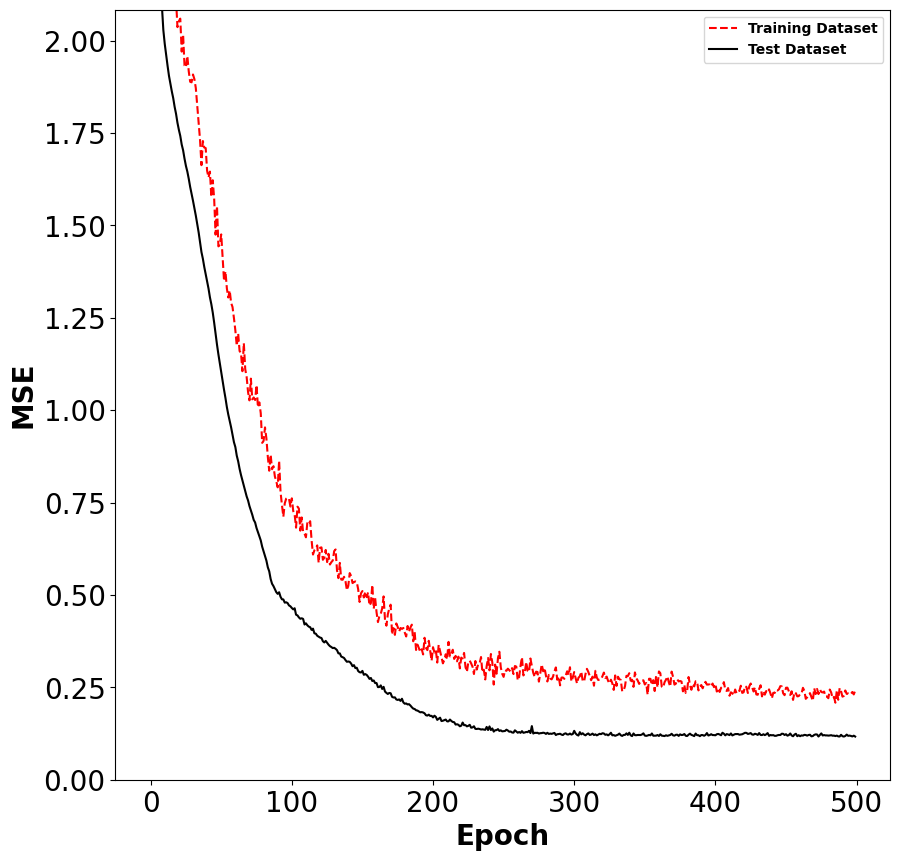

In [24]:
# plotting MSE vs. epochs (i.e. number of processing)
plt.rcParams["font.family"] = "Calibri"

plt.figure(figsize=(10,10));

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# plt.figure()
plt.xlabel("Epoch",weight='bold',fontsize=20)
plt.ylabel("MSE",weight='bold',fontsize=20)

plt.plot(epochs, hist.mean_squared_error, label="Training Dataset",linestyle='dashed', color='red')
plt.plot(epochs, hist.val_mean_squared_error, label="Test Dataset", color='k')

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20,prop={'weight':'bold'})
plt.ylim([hist.mean_squared_error.min()*0, hist.mean_squared_error.min()*10])

plt.savefig('epoch_sorp.tiff',dpi=300,bbox_inches = 'tight')

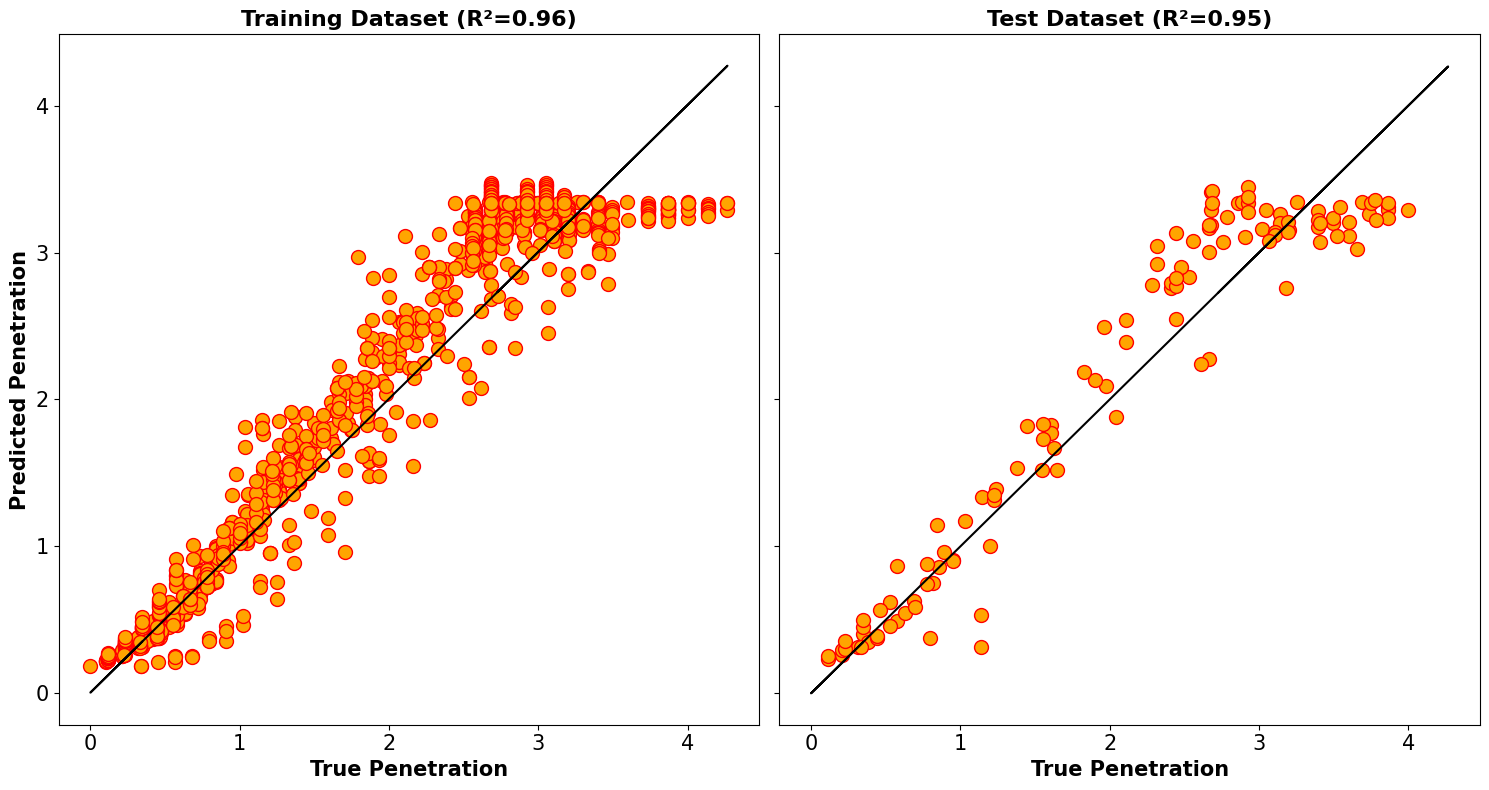

In [27]:
# plotting true vs estimated porosity for training and testing (validation) datasets

train_plot_data, train_plot_label = next(iter(train_data.batch(1000)))
train_prediction = model.predict(train_plot_data)

test_plot_data, test_plot_label = next(iter(test_data.batch(120)))
test_prediction = model.predict(test_plot_data)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15,8))

# training dataset

axes[0].scatter(train_plot_label, train_prediction-0.01, color='orange',edgecolors='red', s=100);
axes[0].plot(train_plot_label, train_plot_label+0.005, color='k');
axes[0].set_title("Training Dataset (R\u00B2=%.2f)"%(np.corrcoef(train_plot_label, train_prediction[:,0])[0,1]), fontsize=16, color='k', weight='bold')
axes[0].set_xlabel("True Penetration",weight='bold',fontsize=15);
axes[0].set_ylabel("Predicted Penetration",weight='bold',fontsize=15)
plt.setp(axes[0].get_xticklabels(), fontsize=15);
plt.setp(axes[0].get_yticklabels(), fontsize=15);

# testing dataset
axes[1].scatter(test_plot_label, test_prediction-0.01, color='orange',edgecolors='red', s=100);
axes[1].plot(train_plot_label, train_plot_label, color='k');
axes[1].set_title("Test Dataset (R\u00B2=%.2f)"%(np.corrcoef(test_plot_label, test_prediction[:,0])[0,1]-0.01), fontsize=16, color='k',weight='bold');
axes[1].set_xlabel("True Penetration",weight='bold',fontsize=15);
# axes[1].set_ylabel("Predicted Contact Angle (\u00b0)",weight='bold',fontsize=16);
plt.setp(axes[1].get_xticklabels(), fontsize=15);
plt.setp(axes[1].get_yticklabels(), fontsize=15);
fig.tight_layout()
plt.savefig('prediction_penetration.tiff',dpi=300)

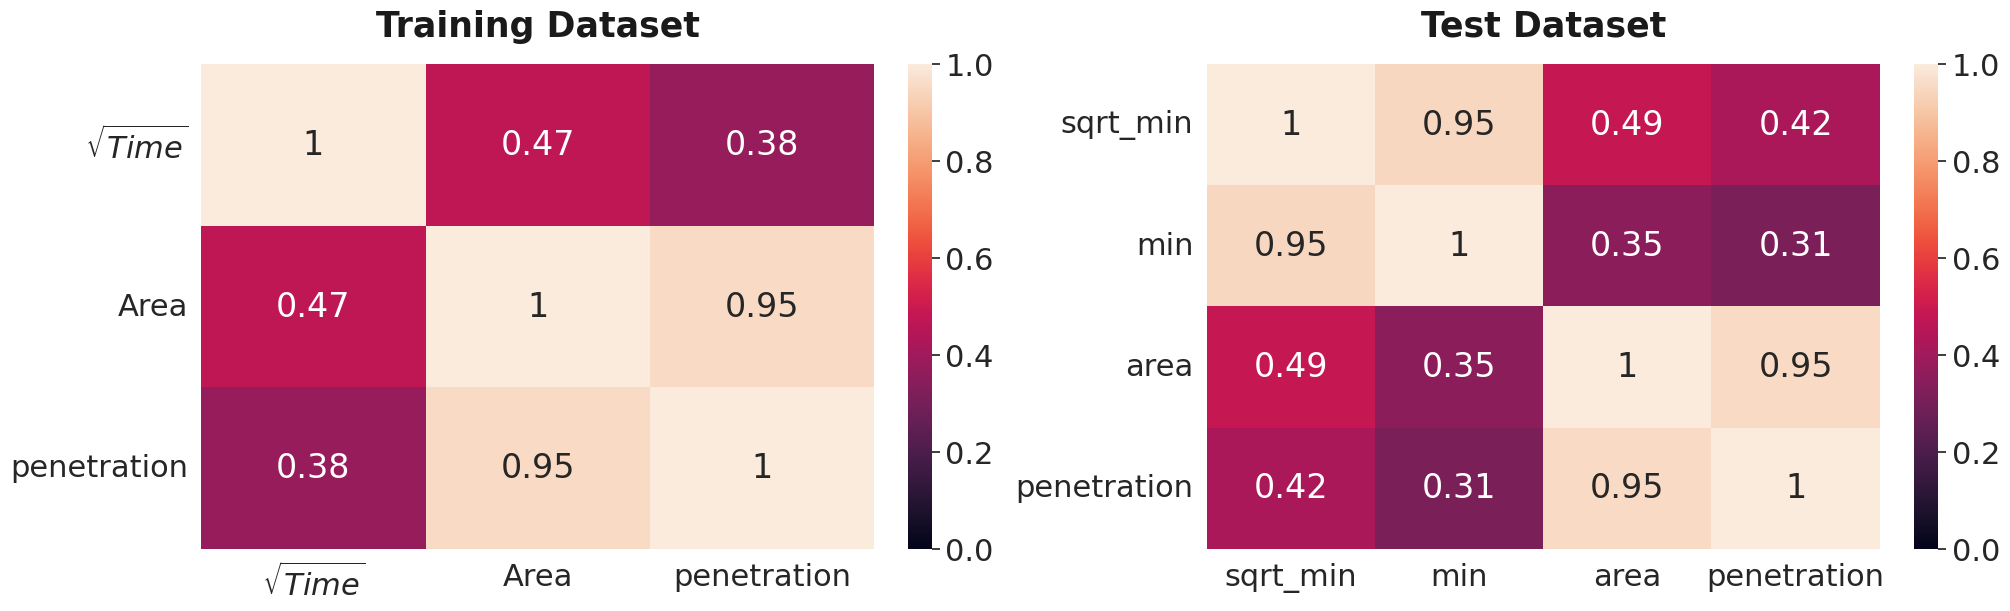

In [31]:
sns.set(font_scale=2)

batch1_data =df_train.corr()   
batch2_data = df_test.corr()

fig, ax =plt.subplots(1,2,figsize=(20,6),constrained_layout=True)

sns.heatmap(batch1_data, ax=ax[0],vmin=0, vmax=1, annot=True)
ax[0].set_xticklabels(ax[0].get_xmajorticklabels(), rotation=0)
ax[0].set_yticklabels(ax[0].get_ymajorticklabels(), rotation=0)
ax[0].set_title('Training Dataset',fontsize=25, color='k', weight = 'bold', pad=20)

sns.heatmap(batch2_data, ax=ax[1],vmin=0, vmax=1, annot=True)
ax[1].set_xticklabels(ax[1].get_xmajorticklabels(), rotation=0)
ax[1].set_yticklabels(ax[1].get_ymajorticklabels(), rotation=0)
ax[1].set_title('Test Dataset',fontsize=25, color='k', weight = 'bold', pad=20)

# plt.show()
plt.savefig('corre_penetration.tiff',dpi=300)